In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *



from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# To identify the sentiment of text
from textblob import TextBlob
from textblob.np_extractors import ConllExtractor

# For Deploy
import pickle
from sklearn.feature_extraction.text import CountVectorizer 


# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('conll2000')

stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tripti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Tripti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Tripti\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


In [2]:
import pandas
tweetsdf=pd.read_csv("Elon_musk.csv",encoding='cp1252')
tweetsdf

,Unnamed: 0,Text
0,1,@kunalb11 I’m an alien
1,2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,3,@joerogan @Spotify Great interview!
3,4,@gtera27 Doge is underestimated
4,5,@teslacn Congratulations Tesla China for amazi...
...,...,...
1994,1995,"@flcnhvy True, it sounds so surreal, but the n..."
1995,1996,@PPathole Make sure to read ur terms &amp; con...
1996,1997,@TeslaGong @PPathole Samwise Gamgee
1997,1998,@PPathole Altho Dumb and Dumber is <U+0001F525...


# Fetching Sentiments

In [3]:
# 1 way -  Using NLTK's SentimentIntensityAnalyzer¶
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way - Using TextBlob¶
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [4]:
sentiments_using_SIA = tweetsdf.Text.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Text
pos,1770
neg,229


In [5]:
sentiments_using_textblob = tweetsdf.Text.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,Text
pos,1785
neg,214


In [6]:
# we will use the Textblob as it shows more positive than the NLKT's sentimentintensityAnalyzer
tweetsdf['sentiment'] = sentiments_using_textblob
tweetsdf.drop('Unnamed: 0', inplace=True, axis=1)
tweetsdf.head()

,Text,sentiment
0,@kunalb11 I’m an alien,neg
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos
2,@joerogan @Spotify Great interview!,pos
3,@gtera27 Doge is underestimated,pos
4,@teslacn Congratulations Tesla China for amazi...,pos


 # Pre-processing

In [7]:
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [8]:
# removing the '@username' as it is not required for the analysis
tweetsdf['tidy_tweets'] = np.vectorize(remove_pattern)(tweetsdf['Text'], "@[\w]*")
tweetsdf.head(10)

,Text,sentiment,tidy_tweets
0,@kunalb11 I’m an alien,neg,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-lev...
2,@joerogan @Spotify Great interview!,pos,Great interview!
3,@gtera27 Doge is underestimated,pos,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execu...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox! https://t.co/9WFKMYu2oj
6,"Frodo was the underdoge,\nAll thought he would...",pos,"Frodo was the underdoge,\nAll thought he would..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,Indeed! Tweets definitely do not represent r...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely


In [9]:
# removing hyperlinks
cleaned_tweets = []

for index, row in tweetsdf.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweetsdf['tidy_tweets'] = cleaned_tweets
tweetsdf.head(10)

,Text,sentiment,tidy_tweets
0,@kunalb11 I’m an alien,neg,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,pos,Great interview!
3,@gtera27 Doge is underestimated,pos,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...",pos,"Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely


In [10]:
# removing tweets with empty texts
tweetsdf = tweetsdf[tweetsdf['tidy_tweets']!='']
tweetsdf.head(10)

,Text,sentiment,tidy_tweets
0,@kunalb11 I’m an alien,neg,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,pos,Great interview!
3,@gtera27 Doge is underestimated,pos,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execut...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!
6,"Frodo was the underdoge,\nAll thought he would...",pos,"Frodo was the underdoge, All thought he would ..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,Indeed! Tweets definitely do not represent rea...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely


In [11]:
# dropping the duplicates
tweetsdf.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweetsdf = tweetsdf.reset_index(drop=True)
tweetsdf

,Text,sentiment,tidy_tweets
0,@kunalb11 I’m an alien,neg,I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-leve...
2,@joerogan @Spotify Great interview!,pos,Great interview!
3,@gtera27 Doge is underestimated,pos,Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execut...
...,...,...,...
1946,"@flcnhvy True, it sounds so surreal, but the n...",pos,"True, it sounds so surreal, but the negative p..."
1947,@PPathole Make sure to read ur terms &amp; con...,pos,Make sure to read ur terms &amp; conditions be...
1948,@TeslaGong @PPathole Samwise Gamgee,pos,Samwise Gamgee
1949,@PPathole Altho Dumb and Dumber is <U+0001F525...,neg,Altho Dumb and Dumber is <U+0001F525><U+0001F525>


In [12]:
# removing stopwords
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweetsdf.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweetsdf['absolute_tidy_tweets'] = cleaned_tweets
tweetsdf.head(20)

,Text,sentiment,tidy_tweets,absolute_tidy_tweets
0,@kunalb11 I’m an alien,neg,I’m an alien,I’m alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-leve...,Ray tracing Cyberpunk HDR next-level. Have tri...
2,@joerogan @Spotify Great interview!,pos,Great interview!,Great interview!
3,@gtera27 Doge is underestimated,pos,Doge is underestimated,Doge underestimated
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execut...,Congratulations Tesla China amazing execution ...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!,Happy New Year Ox!
6,"Frodo was the underdoge,\nAll thought he would...",pos,"Frodo was the underdoge, All thought he would ...","Frodo underdoge, All thought would fail, Himse..."
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,Haha thanks :),Haha thanks :)
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,Indeed! Tweets definitely do not represent rea...,Indeed! Tweets definitely represent real-world...
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely,The entertaining outcome likely


# Tokenizing

In [13]:
tokenized_tweet = tweetsdf['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                         [I’m, alien]
1    [Ray, tracing, Cyberpunk, HDR, next-level., Ha...
2                                  [Great, interview!]
3                               [Doge, underestimated]
4    [Congratulations, Tesla, China, amazing, execu...
Name: absolute_tidy_tweets, dtype: object

# Converting words to Lemma

In [14]:
word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0                                         [I’m, alien]
1    [Ray, tracing, Cyberpunk, HDR, next-level., Ha...
2                                  [Great, interview!]
3                               [Doge, underestimated]
4    [Congratulations, Tesla, China, amazing, execu...
Name: absolute_tidy_tweets, dtype: object

# Feature Extraction
# Key phrases using Textblob

In [15]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweetsdf.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.absolute_tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['’ m alien'],
 ['ray tracing cyberpunk hdr next-level'],
 ['great interview'],
 ['doge underestimated'],
 ['congratulations tesla china amazing execution last year'],
 ['happy new year ox'],
 ['frodo underdoge'],
 [],
 ['tweets', 'real-world time allocation'],
 []]

In [16]:
tweetsdf['key_phrases'] = textblob_key_phrases
tweetsdf.head(10)

,Text,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,@kunalb11 I’m an alien,neg,I’m an alien,I’m alien,[’ m alien]
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,pos,Ray tracing on Cyberpunk with HDR is next-leve...,Ray tracing Cyberpunk HDR next-level. Have tri...,[ray tracing cyberpunk hdr next-level]
2,@joerogan @Spotify Great interview!,pos,Great interview!,Great interview!,[great interview]
3,@gtera27 Doge is underestimated,pos,Doge is underestimated,Doge underestimated,[doge underestimated]
4,@teslacn Congratulations Tesla China for amazi...,pos,Congratulations Tesla China for amazing execut...,Congratulations Tesla China amazing execution ...,[congratulations tesla china amazing execution...
5,Happy New Year of the Ox! https://t.co/9WFKMYu2oj,pos,Happy New Year of the Ox!,Happy New Year Ox!,[happy new year ox]
6,"Frodo was the underdoge,\nAll thought he would...",pos,"Frodo was the underdoge, All thought he would ...","Frodo underdoge, All thought would fail, Himse...",[frodo underdoge]
7,@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :),pos,Haha thanks :),Haha thanks :),[]
8,@flcnhvy @anonyx10 Indeed! Tweets definitely d...,pos,Indeed! Tweets definitely do not represent rea...,Indeed! Tweets definitely represent real-world...,"[tweets, real-world time allocation]"
9,The most entertaining outcome is the most likely,pos,The most entertaining outcome is the most likely,The entertaining outcome likely,[]


# Feature Extraction for Key phrases 

In [17]:
#dropping the key phrases which are empty
tweetsdf2 = tweetsdf[tweetsdf['key_phrases'].str.len()>0]

In [18]:
phrase_sents = tweetsdf2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)
print(bow_phrase_vectorizer.get_feature_names()[100:150])
print(bow_phrase_feature.toarray()[100:150])


['basic', 'battery', 'bay', 'beautiful', 'behalf', 'berlin', 'best', 'beta', 'better', 'big', 'bigger', 'bit', 'bitcoin', 'board', 'boca', 'body', 'booster', 'boring', 'box', 'boys', 'brain', 'brandenburg', 'bringing', 'btw', 'building', 'california', 'called', 'camera', 'canada', 'capable', 'car', 'carbon', 'care', 'cargo', 'cars', 'case', 'cash', 'cell', 'center', 'ch4', 'chain', 'chamber', 'chance', 'change', 'chica', 'china', 'chip', 'christmas', 'civilization', 'class']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)
print(tfidf_phrase_vectorizer.get_feature_names()[100:150])
print(tfidf_phrase_feature.toarray()[100:150])

['basic', 'battery', 'bay', 'beautiful', 'behalf', 'berlin', 'best', 'beta', 'better', 'big', 'bigger', 'bit', 'bitcoin', 'board', 'boca', 'body', 'booster', 'boring', 'box', 'boys', 'brain', 'brandenburg', 'bringing', 'btw', 'building', 'california', 'called', 'camera', 'canada', 'capable', 'car', 'carbon', 'care', 'cargo', 'cars', 'case', 'cash', 'cell', 'center', 'ch4', 'chain', 'chamber', 'chance', 'change', 'chica', 'china', 'chip', 'christmas', 'civilization', 'class']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Sentiment analysis

In [20]:
afinn = pd.read_csv('Afinn.csv', sep=',', encoding='latin-1')
afinn.shape

(2477, 2)

In [21]:
afinn.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [22]:
affinity_scores = afinn.set_index('word')['value'].to_dict()

In [23]:
import string # special operations on strings
import spacy # language models
#Custom function :score each word in a sentence in lemmatised form, 
#but calculate the score for the whole original sentence.
import spacy
nlp = spacy.load("en_core_web_lg")
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [24]:
tweetsdf['sentiment_value'] = tweetsdf['absolute_tidy_tweets'].apply(calculate_sentiment)

In [25]:
tweetsdf.sort_values(by='sentiment_value').tail(10)

,Text,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases,sentiment_value
1568,@Teslarati Aiming to make it super fun!,pos,Aiming to make it super fun!,Aiming make super fun!,[super fun],7
1740,@flcnhvy @yourfavgas @ajtourville I really wan...,pos,I really want to do this! Will be great fun. C...,I really want this! Will great fun. Could LA A...,"[great fun, la austin]",8
1919,@nichegamer I didn’t mind DA2. DA1 was awesome...,pos,I didn’t mind DA2. DA1 was awesome. Mass Effec...,I didn’t mind DA2. DA1 awesome. Mass Effect 2 ...,"[’ t mind da2, mass effect]",8
494,"@Space_Station @SpaceX Wow, Station looks amaz...",pos,"Wow, Station looks amazing!","Wow, Station looks amazing!",[station],8
453,@picot_john @CyberpunkGame It’s a good to grea...,pos,"It’s a good to great game imo, but improving w...","It’s good great game imo, improving may seem l...","[good great game imo, mere surface detail woul…]",10
443,@teslaownerssv It will get absurdly good. Tesl...,pos,It will get absurdly good. Tesla AI/Autopilot ...,It get absurdly good. Tesla AI/Autopilot engin...,"[tesla ai/autopilot engineering awesome, great...",10
1142,Thanks Tesla Team for great work on deliveries...,pos,Thanks Tesla Team for great work on deliveries...,Thanks Tesla Team great work deliveries! For n...,"[thanks tesla team great work deliveries, deli...",10
1323,Great trip to Germany. Support from government...,pos,Great trip to Germany. Support from government...,Great trip Germany. Support government &amp; p...,"[great trip germany, support government]",10
1271,"One way or another, excitement guaranteed! Sup...",pos,"One way or another, excitement guaranteed! Sup...","One way another, excitement guaranteed! Suppor...","[support greater boca, padre, brownsville comm...",11
1351,"@GerberKawasaki Wow, I super loved astronomy (...",pos,"Wow, I super loved astronomy (but took it at Q...","Wow, I super loved astronomy (but took Queens,...","[queens, penn, one favorite class…]",12


In [26]:
# Sentiment score of the whole review
tweetsdf['sentiment_value'].describe()

count    1951.000000
mean        0.741671
std         1.810483
min        -7.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        12.000000
Name: sentiment_value, dtype: float64

C:\Users\Tripti\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiment_value', ylabel='Density'>

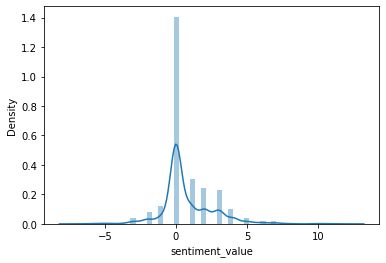

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(tweetsdf['sentiment_value'])

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

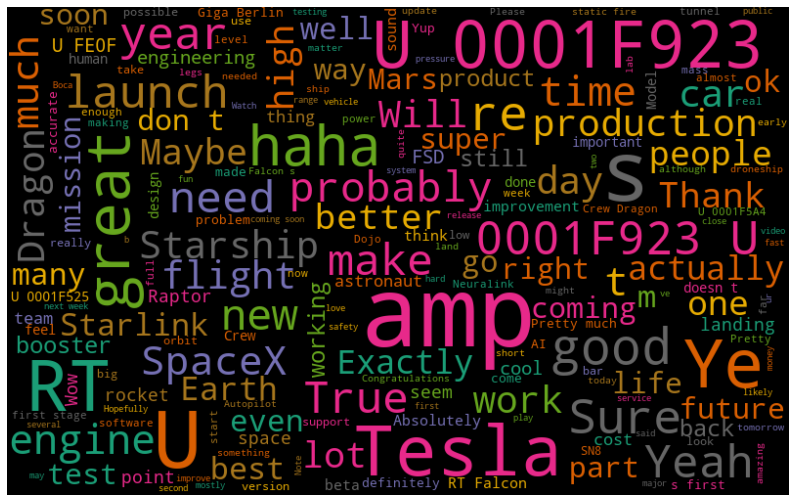

In [29]:
all_words = ' '.join([text for text in tweetsdf['absolute_tidy_tweets'][tweetsdf.sentiment == 'pos']])
generate_wordcloud(all_words)

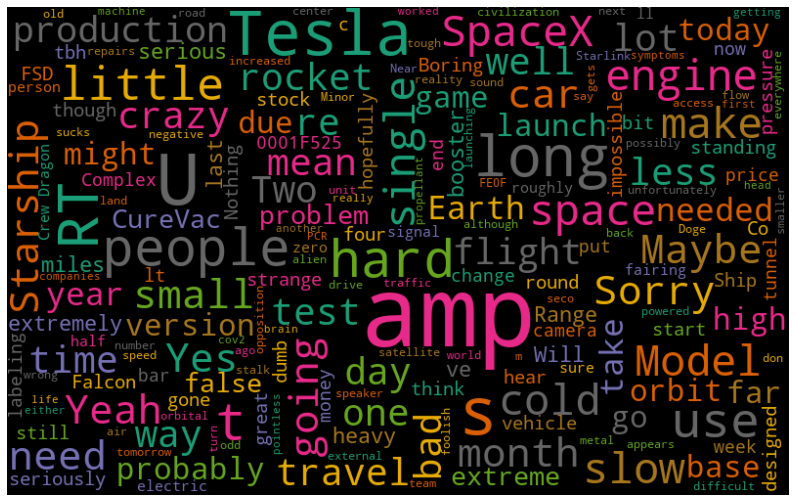

In [30]:
all_words = ' '.join([text for text in tweetsdf['absolute_tidy_tweets'][tweetsdf.sentiment == 'neg']])
generate_wordcloud(all_words)